# Red Neuronal Convolucional

(Práctica, 4 puntos)

Una red neuronal convolucional (CNN por sus siglas en inglés) es un tipo de de red profunda en la que se comparten los pesos en cada capa. Una de las redes colvolucionales más famosas es LeNet5 de Yan LeCun [1]. En este notebook implementaremos la red neuronal convolucional LeNet5 con PyTorch para clasificar tipos de ropa.

Primero hay que notar la aquitectura de la red. Ésta se compone de una parte convolucional y otra parte completamente conectada. La parte convolucional incluye tres capas con maxpooling y la completamente conectada se compone de una capas oculta y una de salida.

Instrucciones: Completa la parte de código marcada con "TODO:"

@juan1rving

<img src="archivos/lenet.png">

[1] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.

In [34]:
# Importamos paquetes
# Cargamos paquetes necesarios

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

#helper was developed by Udacity under MIT license
import helper

cuda:0


In [35]:
# Hiper-parámetros

batch_size = 64

Para este ejemplo usaremos el conjunto de datos [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Fashion-MNIST es un conjunto de datos desarrollado por Zalado que contiene imagenes de ropa asociadas con 10 clases. El conjunto contiene 60,000 ejemplos de entrenamiento y 10,000 para validación. Cada imagen tiene una resolución de 28x28 en un solo canal. Este conjunto comparte la misma estructura y tamaño con el conjunto de datos de MNIST.

A continuación crearemos los objetos Dataset y Dataloader que se encargarán del manejo del conjunto. Además mostraremos algunas estadísticas y ejemplos en el conjunto.

[2] Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747.

In [36]:
# Definimos una transformación de los datos
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) #normalizar a media y desv std

# Descargamos el conjunto de entrenamiento y cargamos mediante un dataLoader
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

# Descargamos el conjunto de validación
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

# Imprimir información estadística del conjunto de datos
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# Nombrar las clases de acuerdo al índice que tienen
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Train data, number of images:  60000
Test data, number of images:  10000


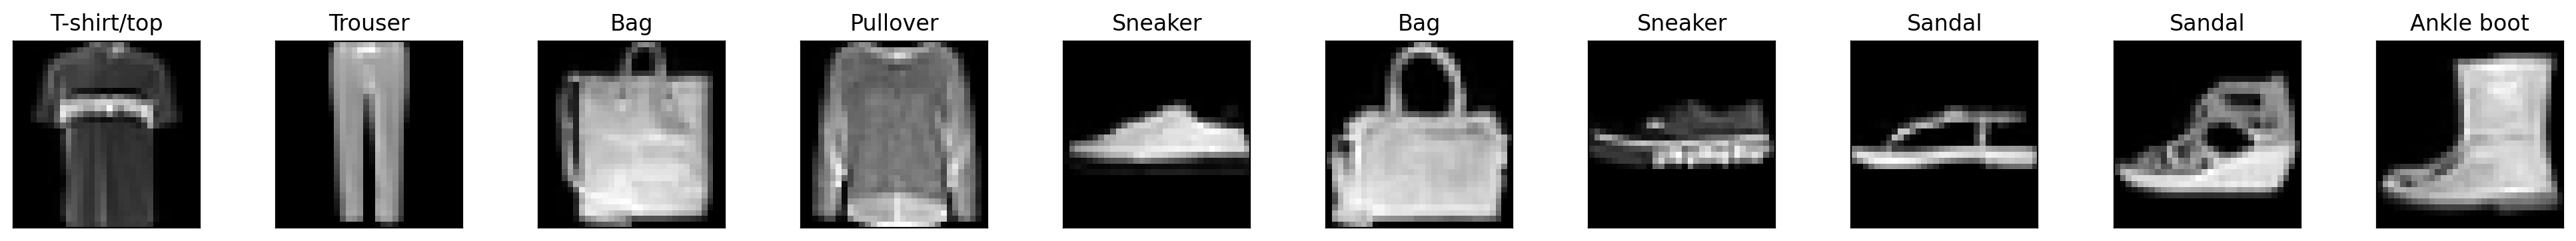

In [37]:
# Obtener un lote de ejemplos
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

display_size = 10

# Graficar los ejemplos junto a las clases que le corresponden
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Creación de la RNC
Si estudiamos la arquitectura obsevaremos que esta compuesta por 2 capas convolucionales, despúes de cada convolución se realiza un max pooling. Se aplana el mapa de características y se agrega una red completamente conectada.

Ejemplo de convolución :

```
self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
```

Ejemplo de capa completamente conectada:
```
self.fc1 = nn.Linear(120, 84)
```

En el comportamiento debemos agregar el comportamiento de la red. Por ejemplo, si queremos que la entrada pase por la convolucional, luego por una activación tipo relu y finalice con un pooling el código sería similar al siguiente:
```
x = self.pool1(F.relu(self.conv1(x)))
```


In [38]:
# Implementación de LeNet5
#TODO: Completar la implementación de LeNet5 (4 puntos)
class LeNet5(nn.Module):
    def __init__(self, n_clases):
        '''
        Construimos la estructura de LeNet5
        
        '''
        super(LeNet5, self).__init__()
        
        # De acuerdo al artículo de LeCun La primera capa está compuesta por 6 kernels de 5x5
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
        
        # Después tenemos una capa maxpooling
        # kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Agregamos otra capa convolucional con 16 kernels de 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Agregamos una última capa convoluciona de 120 filtros de 5x5

        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_clases)
    
    def forward(self, x):
        '''
        Definimos el pase frontal (forward pass)
        '''
        # Agregamos los ReLUs y max pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # capas lineales
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # regresamos el resultado de pasar por softmax
        return F.log_softmax(x, dim=1)

## Entrenamiento y validación


In [39]:
# Instanciar la red
model = LeNet5(10)
model.to(device)
# Definir la función de costo (critetio de optimización)
criterion = nn.NLLLoss()
# Instanciar optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Información de la red
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [41]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            test_loss += criterion(output, labels).item()

            ps = torch.exp(output)
            equality = (labels == ps.max(dim=1)[1])
            accuracy += equality.float().mean()

    return test_loss, accuracy


### Implementación del entrenamiento y validación

En esta sección implementamos el algoritmo de descenso por gradiente y haremos el entrenamiento.

In [42]:
from torch.autograd import Variable

# Antes del descenso por gradiente y el entrenamiento 
# verificaremos que la red está bien implementada a través verificar la exactitud que tiene sin haber sido entrenada.

correct = 0
total = 0

# Iterate through test dataset
for images, labels in testloader:
    
    # warp input images in a Variable wrapper
    images = images.to(device)
    labels = labels.to(device)

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct.item() / total

# print it out!
print('Porcentaje de exactitud antes de entrenar: ', accuracy)

Porcentaje de exactitud antes de entrenar:  5.69


In [43]:
from torch.autograd import Variable

# Hiperparámetros

epochs = 2
steps = 0
running_loss = 0
print_every = 40


# Descenso por gradiente
for e in range(epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # wrap them in a torch Variable
        images, labels = Variable(images), Variable(labels)
        images, labels = images.to(device), labels.to(device)       
        
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 1.664..  Test Loss: 1.182..  Test Accuracy: 0.581
Epoch: 1/2..  Training Loss: 1.013..  Test Loss: 0.894..  Test Accuracy: 0.672
Epoch: 1/2..  Training Loss: 0.784..  Test Loss: 0.828..  Test Accuracy: 0.688
Epoch: 1/2..  Training Loss: 0.756..  Test Loss: 0.710..  Test Accuracy: 0.734
Epoch: 1/2..  Training Loss: 0.702..  Test Loss: 0.671..  Test Accuracy: 0.750
Epoch: 1/2..  Training Loss: 0.664..  Test Loss: 0.714..  Test Accuracy: 0.731
Epoch: 1/2..  Training Loss: 0.635..  Test Loss: 0.643..  Test Accuracy: 0.768
Epoch: 1/2..  Training Loss: 0.644..  Test Loss: 0.637..  Test Accuracy: 0.753
Epoch: 1/2..  Training Loss: 0.581..  Test Loss: 0.590..  Test Accuracy: 0.787
Epoch: 1/2..  Training Loss: 0.573..  Test Loss: 0.579..  Test Accuracy: 0.778
Epoch: 1/2..  Training Loss: 0.547..  Test Loss: 0.592..  Test Accuracy: 0.784
Epoch: 1/2..  Training Loss: 0.565..  Test Loss: 0.550..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.525..  Test Loss: 0.5

### Visualizar los resultados obtenidos

A continuación mostraremos algunos ejemplos de la inferencia que está realizando la red una vez entrenada.

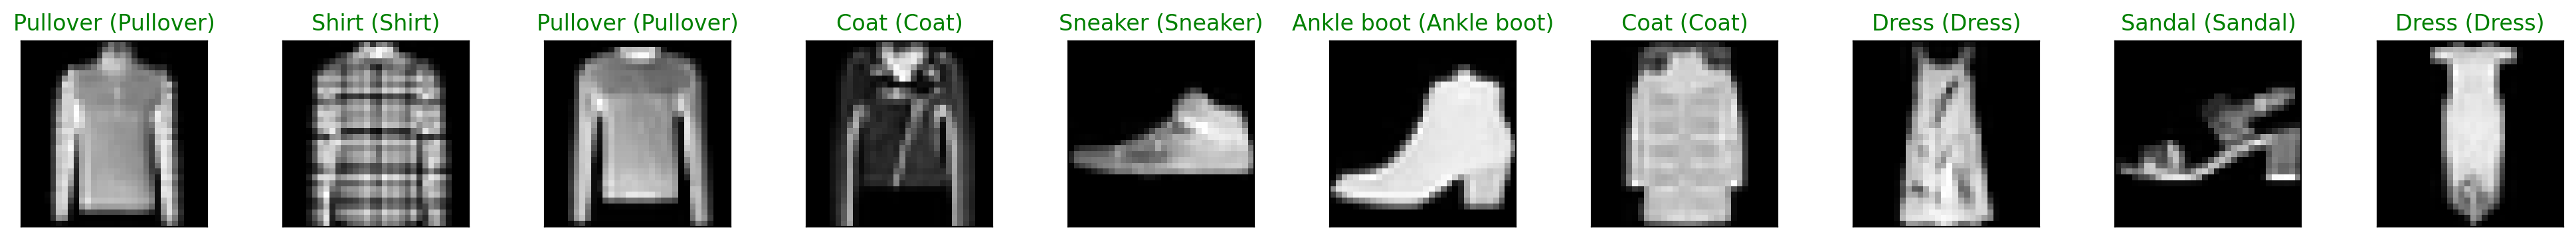

In [44]:
# obtain one batch of test images
display_size = 10

dataiter = iter(testloader)
images, labels = next(dataiter)
# get predictions
#images = (Variable(images, volatile=True))
images = Variable(images)
images = images.to(device)
output = model(images)
output = output.cpu()
output_np = output.data.max(1, keepdim=True)[1].numpy()
preds = np.squeeze(output_np)
images = (images.cpu()).numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))